In [1]:
import pandas as pd
import json
import csv
import sys
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
import numpy as np
from nltk.corpus import stopwords
import string
import emoji
import regex
import string
from datetime import timedelta
import matplotlib.dates as mdates
import seaborn as sn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from unidecode import unidecode as unidec
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
dir_="C:\\Users\\Alex\\Personal-Code\\ACE_592_Dating_Sim\\Wrangled_Data\\"

In [3]:
#reads the csv files into memory for each dating app.
#Data has already been cleaed and all three files share the same columns
df_T = pd.read_csv(dir_ + "sent_Tinder.csv")
df_T = df_T[['userName', 'full_text','clean_text', 'score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]

df_B = pd.read_csv(dir_ + "sent_Bumble.csv")
df_B = df_B[['userName', 'full_text','clean_text', 'score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]

df_H = pd.read_csv(dir_ + "sent_Hinge.csv")
df_H = df_H[['userName', 'full_text','clean_text', 'score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]

In [4]:
#Combines the three datasets into one super set df_Cand then optimizes the model for both a balanced and None class weight.  
df_C1 = pd.concat([df_T, df_B])
df_C = pd.concat([df_C1, df_H])

In [5]:
df_C.head(5)

,userName,full_text,clean_text,score,comp_sent,neg_sent,pos_sent,neu_sent,word_count
0,Nikhilesh Verma,Fake app,fake app,1,-0.4767,0.756,0.000,0.244,8.0
1,Tristan Jones,"I'm not a racist person, l respect all races b...",im not a racist person l respect all races but...,2,0.7109,0.087,0.189,0.724,220.0
2,Lola Racheal,I was banned from using the app i don't know w...,i was banned from using the app i dont know wh...,1,0.3016,0.114,0.199,0.686,112.0
3,Boakiller,Ive been matching with people but they never s...,ive been matching with people but they never s...,1,0.0000,0.000,0.000,1.000,94.0
4,Maddison Macfarlane,"Got banned, don't know why or how? There isn't...",got banned dont know why or how there isnt eve...,1,0.3400,0.140,0.252,0.607,76.0


In [6]:
df_C.shape

(447822, 9)

### With the data from the RF models in mind, we can reasonably assume that models trained on one dating app's data set can be applied to other dating app data sets to get similar results. With that in mind, we are going to train one super model using all three of the datasets here and maximize it's performance. We will do the same for linear regression. To save time and computational power, we will assume that the optimial parameters are the same as those determined in this original grid searches. 

### Four models will be trained: two RF and two LR models, each with one None class weight and one balanced class weight 

#### Worth Noting. These models will be trained using word count as an additional feature, which may be a detriment later on depending on the length of the reviews. May retrain the models without word count later...?

In [128]:
def get_data(df):
    df_data = df[['score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]
    df_data = df_data.loc[df_data['score'] != 0]

    #all missing data has already been removed. There should be no need to account for it here
    x = df_data[['comp_sent', 'pos_sent', 'neg_sent', 'neu_sent', 'word_count']]
    y = df_data['score']
    return x,y

In [129]:
from sklearn.utils import shuffle
k_fold = StratifiedKFold(n_splits=5, shuffle=True)

## Change Log: 

- Created super model with all features except word count then tested the models on the Amazon data. Stored the results in a df below. None log regression actually outperforms the other three by a healthy margin. 
- Reran the model with word count 

### To evaluate the accuracy of the models, the weighted F-scores will be calculated. This will hopefully give us a better idea of the weighted accuracy in addition to the total accuracy. 

Micro-FS (usually referred to as simply FS) is a global performance metric that puts more emphasis on the most represented labels in the data set by treating all samples with the same level of importance. Labels that are very rare in the dataset may not be intended to influence the overall micro-FS heavily if the model is performing well on the other more common classes. Micro-FS is defined as the harmonic mean of the precision and recall: 

Micro FS = 2×((precision×recall))/((precision+recall) )

Macro-FS (short for macro-averaged F1 score) is used to assess the quality of problems with multiple classes. The macro-FS gives the same importance to each class, with low values for models that only perform well on the common classes while performing poorly on the classes with less data. The macro-FS is defined as the mean of class-wise FS in:

Macro-FS = 1/N ∑_(i=1)^N〖FS〗_i , where i is the class index and N is the number of classes/labels.

The weighted-average FS represents the weighted average of all class FS values, and can be used to more wholly capture the model’s ability to accurately predict each class, even when some classes have many more observations than others. This metric is calculated by taking the mean of all per-class F1 scores while considering the number of actual occurrences of each class in the dataset.

Weighted- FS = 1/H ∑_(i=1)^N〖|i|×FS〗_i , where i and N are as above, and H is the total number of aggregated elements across all classes (Cominola et al. 2021). 

The weighted-FS formulation modifies the macro-FS to account for class imbalance, while imbalance is not considered in micro-FS and macro-FS.

#### RF None class weight

In [130]:
#Gets x and y data, and then splits that data into training and testing data
x, y = get_data(df_C)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

model1= RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_depth = 10, class_weight = None, n_jobs = -1)
model1.fit(x_train, y_train)
model1.score(x_test,y_test)

fold= StratifiedKFold(n_splits=10, shuffle=True)
y_predict = cross_val_predict(model1,x,y,cv=fold)
cm_1 = confusion_matrix(y_predict,y)

In [131]:
model1.score(x_test,y_test)

0.6625244236029699

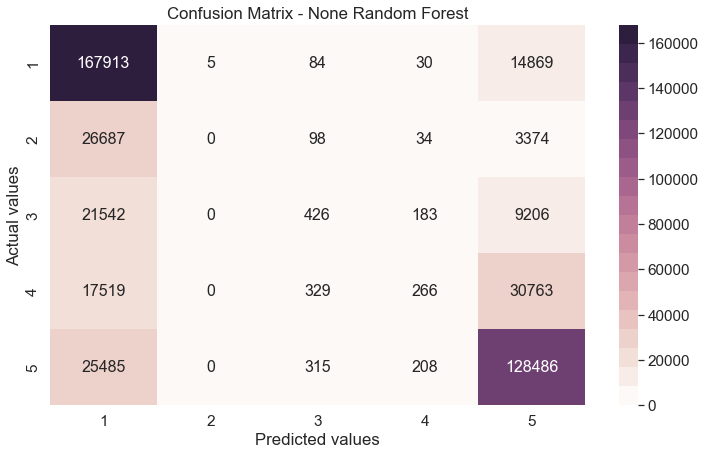

In [132]:
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_1.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - None Random Forest');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

This was the highest performing model. You can see that it generally gets the 1's and 5'r right, and on average it tends to think that the 4's are 5's and the 2's are 1's, which isn't bad all things considered. Interestingly it does tend to assime that most 3's are 1's. All in all, it's pretty good at guessing wither or not someone liked the product or not on a binary level. 

#### RF balanced class weight

In [133]:
#Gets x and y data, and then splits that data into training and testing data
x, y = get_data(df_C)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

model2= RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_depth = 10, 
                               class_weight = 'balanced', n_jobs = -1)
model2.fit(x_train, y_train)
model2.score(x_test,y_test)

fold= StratifiedKFold(n_splits=10, shuffle=True)
y_predict = cross_val_predict(model2,x,y,cv=fold)
cm_2 = confusion_matrix(y_predict,y)

In [134]:
model2.score(x_test,y_test)

0.48782448501088593

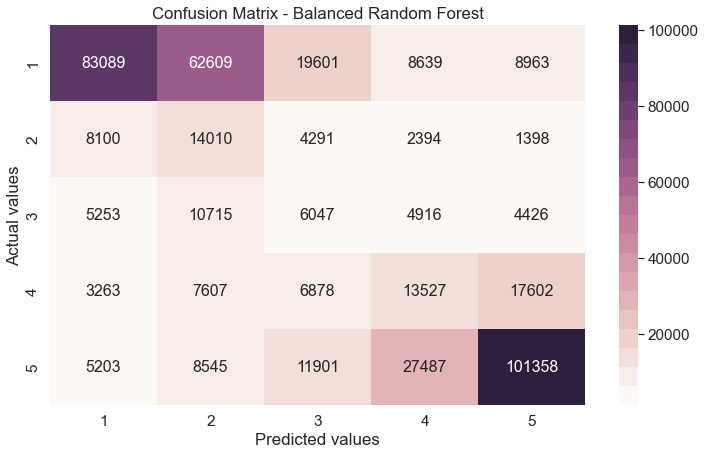

In [135]:
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_2.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - Balanced Random Forest');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

#### Logistic Regression None class weight

In [136]:
#Gets x and y data, and then splits that data into training and testing data
x, y = get_data(df_C)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

model3= LogisticRegression(C=10, penalty = 'l2', solver = 'lbfgs', multi_class='multinomial', n_jobs = -1, max_iter=200000)
model3.fit(x_train, y_train)
model3.score(x_test,y_test)

fold= StratifiedKFold(n_splits=10, shuffle=True)
y_predict = cross_val_predict(model3,x,y,cv=fold)
cm_3 = confusion_matrix(y_predict,y)

In [137]:
model3.score(x_test,y_test)

0.6377602858259365

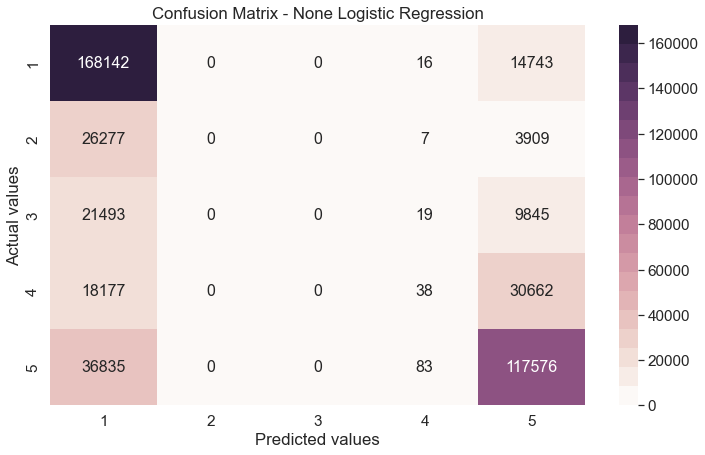

In [138]:
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_3.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - None Logistic Regression');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

#### LR Balanced Class Weight

In [139]:
#Gets x and y data, and then splits that data into training and testing data
x, y = get_data(df_C)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

model4= LogisticRegression(C=10, penalty = 'l2', solver = 'lbfgs', multi_class='multinomial', n_jobs = -1, 
                           max_iter=200000, class_weight = 'balanced')
model4.fit(x_train, y_train)
model4.score(x_test,y_test)

fold= StratifiedKFold(n_splits=10, shuffle=True)
y_predict = cross_val_predict(model4,x,y,cv=fold)
cm_4 = confusion_matrix(y_predict,y)

In [140]:
model4.score(x_test,y_test)

0.502607045162731

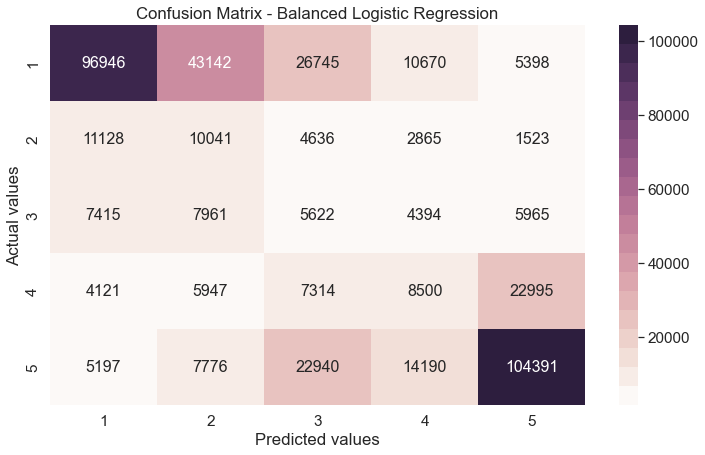

In [141]:
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_4.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - Balanced Logistic Regression');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

## Now let's test them using the Amazon Review data

In [91]:
df_A = pd.read_csv(dir_ + "sent_Amazon.csv")

In [92]:
df_A.head(5)

,Unnamed: 0,full_text,clean_text,score,comp_sent,neg_sent,pos_sent,neu_sent,word_count
0,0,I initially had trouble deciding between the p...,i initially had trouble deciding between the p...,5.0,0.9799,0.038,0.168,0.794,1030.0
1,1,Allow me to preface this with a little history...,allow me to preface this with a little history...,5.0,0.9868,0.041,0.146,0.814,1382.0
2,2,I am enjoying it so far. Great for reading. Ha...,i am enjoying it so far great for reading had ...,4.0,0.4364,0.181,0.223,0.596,176.0
3,3,I bought one of the first Paperwhites and have...,i bought one of the first paperwhites and have...,5.0,0.9734,0.030,0.104,0.866,1633.0
4,4,I have to say upfront - I don't like coroporat...,i have to say upfront i dont like coroporate ...,5.0,0.9922,0.095,0.195,0.710,1854.0


In [93]:
df_A.shape

(3617, 9)

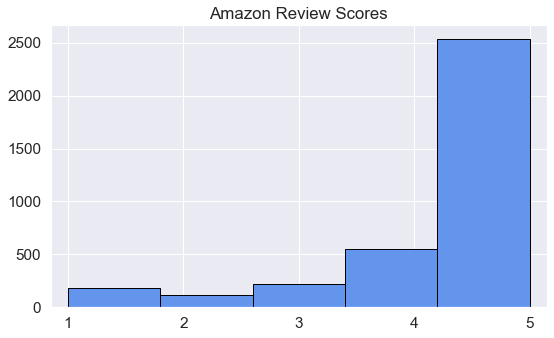

In [152]:
#plots the overall scores of the three apps over their lifespans
fig, axs = plt.subplots(1, 1, tight_layout=True, sharey=False, 
                        figsize = (8,5))
                       #title = 'Star Ratings for Tinder, Bumble, and Hinge')

# ax.set_xlim(1,5)
# ax.set_xticks([1,2,3,4,5])

axs.hist(df_A['score'], bins = 5, color = "cornflowerblue", edgecolor = 'black')
axs.title.set_text('Amazon Review Scores')
axs.set_xlim(0.85,5.15)
axs.set_xticks([1,2,3,4,5])

In [143]:
#This function gathers the testing data and actual output y's for the model testing and confusion matricies. 
def get_test(df):
    df_data = df[['score', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent', 'word_count']]
    df_data = df_data.loc[df_data['score'] != 0]

    #all missing data has already been removed. There should be no need to account for it here
    x_test = df_data[['comp_sent', 'pos_sent', 'neg_sent', 'neu_sent', 'word_count']]
    y_actual = df_data['score']
    return x_test,y_actual

#### RF None Weight

In [144]:
#gathers x_test and y_actual from Bumble
x_test, y_actual = get_test(df_A)
y_pred = model1.predict(x_test)
score1 = model1.score(x_test, y_actual)

weighted_1_fs =cross_val_score(model1,x_test,y_actual,cv=k_fold,scoring='f1_weighted') 
micro_1_fs=cross_val_score(model1, x_test,y_actual,cv=k_fold, scoring='f1_micro')
macro_1_fs=cross_val_score(model1, x_test,y_actual, cv=k_fold, scoring='f1_macro')

print('the score is '+ str(score1))
print('the weighted f-score is '+ str(np.mean(weighted_1_fs)))
print('the micro f-score is ' + str(np.mean(micro_1_fs)))
print('the macro f-score is ' + str(np.mean(macro_1_fs)))

the score is 0.4888028753110312
the weighted f-score is 0.7404928234085891
the micro f-score is 0.77439765250682
the macro f-score is 0.5545092503650959


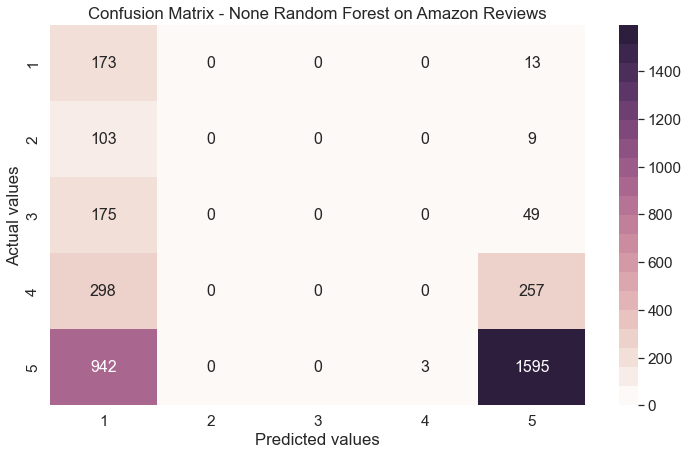

In [145]:
cm_RFN = confusion_matrix(y_pred,y_actual)
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_RFN.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - None Random Forest on Amazon Reviews');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

#### RF Balanced Weight

In [146]:
#gathers x_test and y_actual from Bumble
x_test, y_actual = get_test(df_A)
y_pred = model2.predict(x_test)
score2 = model2.score(x_test, y_actual)

weighted_1_fs =cross_val_score(model2,x_test,y_actual.values,cv=k_fold,scoring='f1_weighted') 
micro_1_fs=cross_val_score(model2, x_test,y_actual.values,cv=k_fold, scoring='f1_micro')
macro_1_fs=cross_val_score(model2, x_test,y_actual.values, cv=k_fold, scoring='f1_macro')

print('the score is '+ str(score2))
print('the weighted f-score is '+ str(np.mean(weighted_1_fs)))
print('the micro f-score is ' + str(np.mean(micro_1_fs)))
print('the macro f-score is ' + str(np.mean(macro_1_fs)))

the score is 0.2922311307713575
the weighted f-score is 0.7357383479833525
the micro f-score is 0.7229854886407924
the macro f-score is 0.5574644486363916


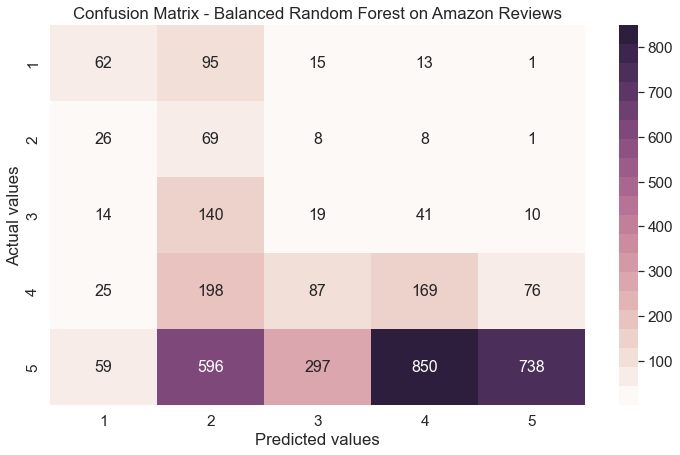

In [147]:
cm_RFB = confusion_matrix(y_pred,y_actual)
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_RFB.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - Balanced Random Forest on Amazon Reviews');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

#### LR None Weight

In [148]:
#gathers x_test and y_actual from Bumble
x_test, y_actual = get_test(df_A)
y_pred = model3.predict(x_test)
score3 = model3.score(x_test, y_actual)

weighted_1_fs =cross_val_score(model3,x_test,y_actual.values,cv=k_fold,scoring='f1_weighted') 
micro_1_fs=cross_val_score(model3, x_test,y_actual.values,cv=k_fold, scoring='f1_micro')
macro_1_fs=cross_val_score(model3, x_test,y_actual.values, cv=k_fold, scoring='f1_macro')

print('the score is '+ str(score3))
print('the weighted f-score is '+ str(np.mean(weighted_1_fs)))
print('the micro f-score is ' + str(np.mean(micro_1_fs)))
print('the macro f-score is ' + str(np.mean(macro_1_fs)))

the score is 0.42493779375172797
the weighted f-score is 0.5997373375161166
the micro f-score is 0.7061098247785853
the macro f-score is 0.2317746646727848


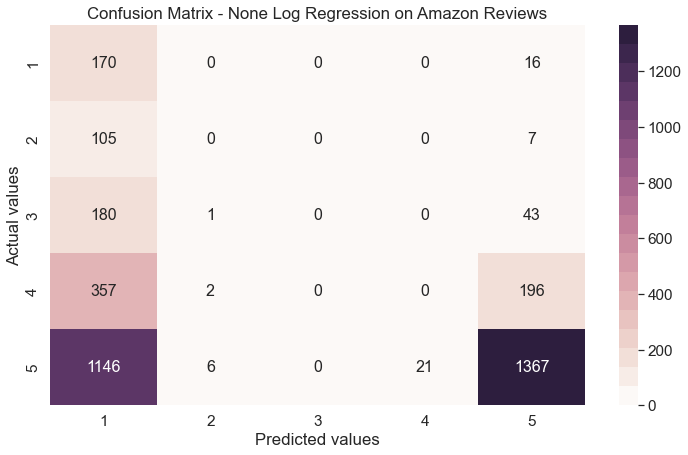

In [149]:
cm_LRN = confusion_matrix(y_pred,y_actual)
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_LRN.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - None Log Regression on Amazon Reviews');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

#### LR Balanced Weight

In [150]:
#gathers x_test and y_actual from Bumble
x_test, y_actual = get_test(df_A)
y_pred = model4.predict(x_test)
score4 = model4.score(x_test, y_actual)

weighted_1_fs =cross_val_score(model4,x_test,y_actual.values,cv=k_fold,scoring='f1_weighted') 
micro_1_fs=cross_val_score(model4, x_test,y_actual.values,cv=k_fold, scoring='f1_micro')
macro_1_fs=cross_val_score(model4, x_test,y_actual.values, cv=k_fold, scoring='f1_macro')

print('the score is '+ str(score4))
print('the weighted f-score is '+ str(np.mean(weighted_1_fs)))
print('the micro f-score is ' + str(np.mean(micro_1_fs)))
print('the macro f-score is ' + str(np.mean(macro_1_fs)))

the score is 0.3248548520873652
the weighted f-score is 0.5108736055477536
the micro f-score is 0.47027234588844824
the macro f-score is 0.32050983819275214


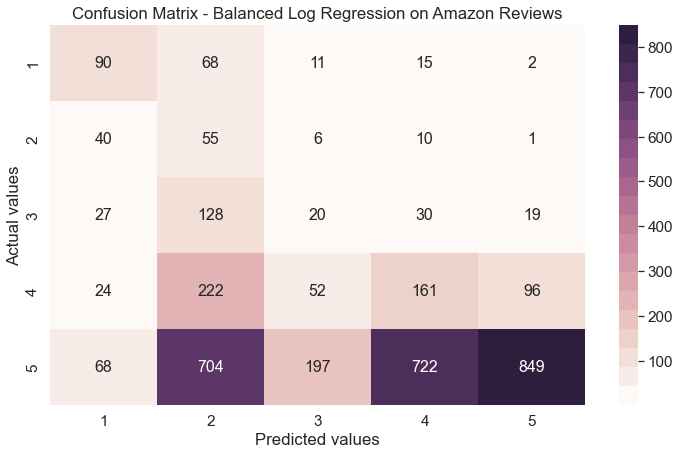

In [151]:
cm_LRB = confusion_matrix(y_pred,y_actual)
#reused code for the confusion matrix
cmap= sn.cubehelix_palette(light=0.98, dark=0.15, n_colors=20)
# cm_1 = confusion_matrix(y_pred,y_test)
df_cm = pd.DataFrame(cm_LRB.T, range(5), range(5))
plt.figure(figsize=(12,7))
sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap=cmap, fmt='d',ax=ax) # font size
ax.set_xlabel('Predicted values');ax.set_ylabel('Actual values'); 
ax.set_title('Confusion Matrix - Balanced Log Regression on Amazon Reviews');
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5']); 
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])
#plt.savefig("D:\\CM1-kfold.svg", format="svg")
plt.show()

### Results of the models when applied to the Amazon Review Data

In [127]:
#hard coded the results into a table df for all features including word count
df_results_noWC = pd.DataFrame(
    {"Model" : ['Random Forest', 'Random Forest', 'Logistic Regression', 'Logistic Regression'],
     "Class_Weight" : ['None', 'Balanced', 'None', 'Balanced'],
     "Score" : [0.4830, 0.2853 , 0.6215, 0.3202],
     "Weighted-FS" : [0.7230, 0.7164, 0.6022, 0.5220],
     "Micro-FS" : [0.7730, 0.7064, 0.7069, 0.4606],
     "Macro-FS" : [0.5472, 0.5364, 0.2395, 0.3110]})

df_results_noWC

,Model,Class_Weight,Score,Weighted-FS,Micro-FS,Macro-FS
0,Random Forest,None,0.4830,0.7230,0.7730,0.5472
1,Random Forest,Balanced,0.2853,0.7164,0.7064,0.5364
2,Logistic Regression,None,0.6215,0.6022,0.7069,0.2395
3,Logistic Regression,Balanced,0.3202,0.5220,0.4606,0.3110


In [126]:
df_results_WC = pd.DataFrame(
    {"Model" : ['Random Forest', 'Random Forest', 'Logistic Regression', 'Logistic Regression'],
     "Class_Weight" : ['None', 'Balanced', 'None', 'Balanced'],
     "Score" : [0.6464,0.4613,0.6341, 0.4864],
     "Weighted-FS" : [0.5552, 0.5158, 0.5443, 0.5368],
     "Micro-FS" : [0.6450, 0.4553, 0.6342, 0.4871],
     "Macro-FS" : [0.2980, 0.2883, 0.2883, 0.3620]})

df_results_WC

,Model,Class_Weight,Score,Weighted-FS,Micro-FS,Macro-FS
0,Random Forest,None,0.6464,0.5552,0.6450,0.2980
1,Random Forest,Balanced,0.4613,0.5158,0.4553,0.2883
2,Logistic Regression,None,0.6341,0.5443,0.6342,0.2883
3,Logistic Regression,Balanced,0.4864,0.5368,0.4871,0.3620


### So the issue with training on dating app data is that most of the reviews are 1 or 5 stars, so they really struggle with the Amazon reviews that are mostly all 5 star reviews. 